In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import the Required Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

#IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate


$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [3]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Unet Model

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. 

In [4]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 16
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [5]:
model = unet()

# Summary of the model

Includes the type, output shape, parammeters of each layer.

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

# summarize filter shapes

Each convolutional layer has two sets of weights.

One is the block of filters and the other is the block of bias values. We can retrieve these weights and then summarize their shape.

In [7]:
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape) 

conv2d (3, 3, 3, 16)
conv2d_1 (3, 3, 16, 16)
conv2d_2 (3, 3, 16, 32)
conv2d_3 (3, 3, 32, 32)
conv2d_4 (3, 3, 32, 64)
conv2d_5 (3, 3, 64, 64)
conv2d_6 (3, 3, 64, 128)
conv2d_7 (3, 3, 128, 128)
conv2d_8 (3, 3, 128, 256)
conv2d_9 (3, 3, 256, 256)
conv2d_10 (3, 3, 256, 512)
conv2d_11 (3, 3, 512, 512)
conv2d_12 (3, 3, 512, 1024)
conv2d_13 (3, 3, 1024, 1024)
conv2d_transpose (2, 2, 64, 1024)
conv2d_14 (3, 3, 576, 512)
conv2d_15 (3, 3, 512, 512)
conv2d_transpose_1 (2, 2, 32, 512)
conv2d_16 (3, 3, 288, 256)
conv2d_17 (3, 3, 256, 256)
conv2d_transpose_2 (2, 2, 16, 256)
conv2d_18 (3, 3, 144, 128)
conv2d_19 (3, 3, 128, 128)
conv2d_transpose_3 (2, 2, 8, 128)
conv2d_20 (3, 3, 72, 64)
conv2d_21 (3, 3, 64, 64)
conv2d_transpose_4 (2, 2, 4, 64)
conv2d_22 (3, 3, 36, 32)
conv2d_23 (3, 3, 32, 32)
conv2d_transpose_5 (2, 2, 2, 32)
conv2d_24 (3, 3, 18, 32)
conv2d_25 (3, 3, 32, 32)
conv2d_26 (1, 1, 32, 1)


# retrieve and count of weights from the 1,2,3 hidden layers 

In [8]:
# weights from the 1 hidden layer
from numpy.ma.core import count
filters_1, biases_1 = model.layers[1].get_weights()

print(f'Count of weights from the 1 hidden layer is : {count(filters_1) + 1}\n')
print(f'filters from the 1 hidden layer is: {filters_1}\n\n')
print(f'biases from the 1 hidden layer is: {biases_1}')

Count of weights from the 1 hidden layer is : 433

filters from the 1 hidden layer is: [[[[ 0.18481773  0.08152542  0.1636872  -0.12231044 -0.17943121
    -0.16057098 -0.07887491 -0.11299167 -0.17336403 -0.18143362
    -0.02025133 -0.11603564  0.18703544 -0.1533739  -0.1542466
    -0.05184697]
   [-0.10289219  0.05493715  0.1720345  -0.12315921  0.13411099
     0.14235559  0.11211619 -0.14143689  0.04454324  0.15598464
     0.1035817   0.03476496 -0.13325368  0.1843656   0.10723406
    -0.11821848]
   [ 0.06954086 -0.06317811  0.17548347 -0.00492504  0.13129628
     0.1721032   0.0187241   0.13005781  0.16145211 -0.06597476
    -0.09564273  0.03100151  0.07364032 -0.14618433  0.04606003
     0.16837677]]

  [[ 0.14607733 -0.15291521 -0.18613341  0.01508062 -0.15001138
     0.13926509 -0.08530352  0.00407803 -0.01378687  0.02340241
    -0.10901605 -0.02403297  0.09239677 -0.0455133   0.16216078
    -0.16697909]
   [ 0.1662142  -0.09904229 -0.09073046  0.04499903  0.075212
    -0.0604267

In [9]:
# weights from the 2 hidden layer
from numpy.ma.core import count
filters_2, biases_2 = model.layers[2].get_weights()

print(f'Count of weights from the 2 hidden layer is : {count(filters_2) + 1}\n')
print(f'filters from the 2 hidden layer is: {filters_2}\n\n')
print(f'biase from the 2 hidden layer is: {biases_2}')

Count of weights from the 2 hidden layer is : 2305

filters from the 2 hidden layer is: [[[[-0.14086473  0.1167241  -0.07553469 ...  0.07041146 -0.00116237
     0.03940047]
   [-0.07652705  0.04116689 -0.10029299 ... -0.11389198  0.01412179
     0.06302989]
   [-0.11242496 -0.09910853  0.12421387 ...  0.09763946  0.0996823
     0.13882405]
   ...
   [-0.06389757  0.01781259  0.02235618 ... -0.06116947 -0.0962659
     0.0490614 ]
   [ 0.04385379 -0.07100635 -0.05734126 ... -0.01022802  0.10787013
     0.06741796]
   [-0.00948676  0.12481135 -0.00414564 ...  0.05845244  0.14280376
    -0.10935816]]

  [[ 0.02230667  0.07797818 -0.093914   ... -0.00241983  0.05187552
     0.02382983]
   [-0.0469484   0.06999311 -0.03681886 ...  0.02607737  0.04108395
    -0.06552344]
   [ 0.08007391  0.0699802  -0.11278884 ...  0.07135306 -0.05504747
    -0.10042638]
   ...
   [-0.06055358  0.01159056  0.03512327 ... -0.09933607 -0.11102915
     0.0363771 ]
   [-0.11898947 -0.12553798 -0.04826149 ...  0.0

# normalize filter values to 0-1

In [10]:
f_min, f_max = filters_1.min(), filters_1.max()
filters = (filters_1 - f_min) / (f_max - f_min)
filters

array([[[[0.9940679 , 0.71777344, 0.93754625, 0.17253724, 0.01974609,
          0.07019494, 0.28872204, 0.19746383, 0.03597508, 0.0143899 ,
          0.44553298, 0.18932158, 1.        , 0.08944626, 0.08711189,
          0.3610185 ],
         [0.2244787 , 0.64665306, 0.95987433, 0.1702669 , 0.8584335 ,
          0.8804868 , 0.79960006, 0.12137631, 0.6188506 , 0.9169429 ,
          0.77677137, 0.59269494, 0.14326541, 0.99285847, 0.786541  ,
          0.18348274],
         [0.6857162 , 0.33070904, 0.9690999 , 0.48652896, 0.85090446,
          0.96005803, 0.5497875 , 0.84759176, 0.9315677 , 0.32322836,
          0.24387014, 0.58262813, 0.6966818 , 0.10867749, 0.6229078 ,
          0.95009035]],

        [[0.890442  , 0.09067319, 0.00181852, 0.5400417 , 0.09844059,
          0.8722201 , 0.27152628, 0.5106111 , 0.46282464, 0.56230146,
          0.20809814, 0.4354176 , 0.746853  , 0.3779603 , 0.9334633 ,
          0.05305402],
         [0.9443057 , 0.23477674, 0.25700986, 0.6200698 , 0.700885

# plot first few filters

plot of the first 4 filters out of 16 filters of the first hidden convolutional layer in the Unet model in three channels of filters



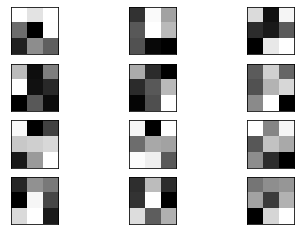

In [11]:
n_filters, ix = 4 , 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in selfscale
		#plt.imshow(f[:, :, j], cmap=None)
	  #plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
		
# show the figure
plt.show()

#summarize feature map

output shapes and name as only for the convolutional layers.

In [12]:
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

1 conv2d (None, 256, 256, 16)
2 conv2d_1 (None, 256, 256, 16)
4 conv2d_2 (None, 128, 128, 32)
5 conv2d_3 (None, 128, 128, 32)
7 conv2d_4 (None, 64, 64, 64)
8 conv2d_5 (None, 64, 64, 64)
10 conv2d_6 (None, 32, 32, 128)
11 conv2d_7 (None, 32, 32, 128)
13 conv2d_8 (None, 16, 16, 256)
14 conv2d_9 (None, 16, 16, 256)
16 conv2d_10 (None, 8, 8, 512)
17 conv2d_11 (None, 8, 8, 512)
19 conv2d_12 (None, 4, 4, 1024)
20 conv2d_13 (None, 4, 4, 1024)
21 conv2d_transpose (None, 8, 8, 64)
23 conv2d_14 (None, 8, 8, 512)
24 conv2d_15 (None, 8, 8, 512)
25 conv2d_transpose_1 (None, 16, 16, 32)
27 conv2d_16 (None, 16, 16, 256)
28 conv2d_17 (None, 16, 16, 256)
29 conv2d_transpose_2 (None, 32, 32, 16)
31 conv2d_18 (None, 32, 32, 128)
32 conv2d_19 (None, 32, 32, 128)
33 conv2d_transpose_3 (None, 64, 64, 8)
35 conv2d_20 (None, 64, 64, 64)
36 conv2d_21 (None, 64, 64, 64)
37 conv2d_transpose_4 (None, 128, 128, 4)
39 conv2d_22 (None, 128, 128, 32)
40 conv2d_23 (None, 128, 128, 32)
41 conv2d_transpose_5 (None, 256,

#design a new model

define a new model that outputs a feature map from the first convolutional layer or each layer.

Making a prediction with this model will give the feature map for the first convolutional layer for a given provided input image.



In [13]:
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [14]:
from tensorflow.keras.preprocessing.image import img_to_array
from keras.models import Model

from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
# load the image with the required shape
img = load_img('/content/drive/MyDrive/images.jpg', target_size=(256, 256))

In [15]:
# convert the image to an array
img = np.array(img.resize((256, 256)))/255.
# expand dimensions so that it represents a single 'sample'
#img = expand_dims(img, axis=0)
img = img[:,:,0:3]

In [16]:
# get feature map for first hidden layer
feature_maps = model.predict(np.expand_dims(img, 0))

1/1 [==============================] - 3s 3s/step


the result will be a feature map with (256 * 256 * 16).
plot all 16 two-dimensional images as an 4 * 4 square of images.

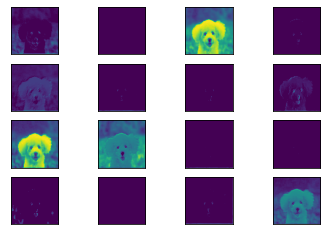

In [17]:
# plot all 16 maps in an 4*4 squares
square = 4
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap=None)
		ix += 1
# show the figure
plt.show()

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


# plot the feature maps from the output of other specific convolutional layers

There are seven main blocks in the image that end in a pooling layer. The layer indexes of the last convolutional layer in each block are [2, 5, 8, 11, 14, 17, 20].

define a new model that has for each of the last convolutional layer in each block.

1/1 [==============================] - 2s 2s/step


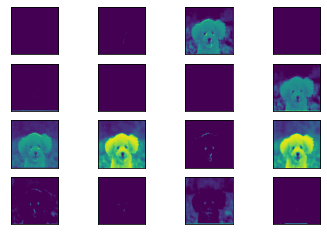

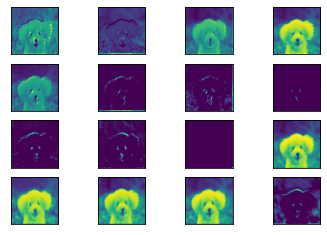

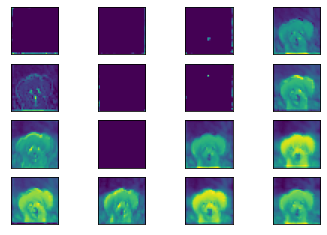

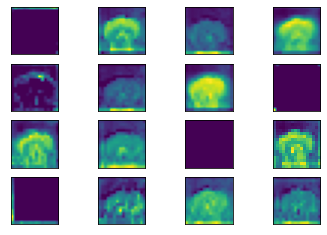

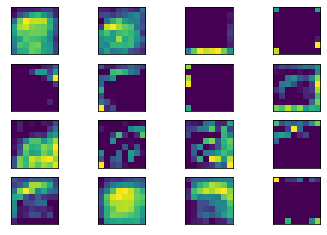

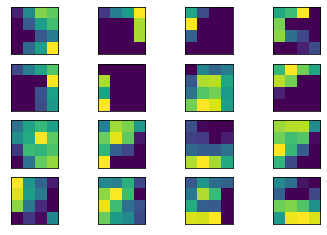

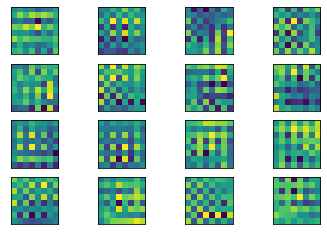

In [19]:
# visualize feature maps output from each block in the vgg model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow.keras.preprocessing import preprocess_input
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = unet()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 8, 11, 14, 17, 20]
outputs = [model.layers[i+1].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img('/content/drive/MyDrive/images.jpg', target_size=(256, 256))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
#img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 4
for fmap in feature_maps:
	# plot all 16 maps in an 4*4 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in selfscale
			pyplot.imshow(fmap[0, :, :, ix-1], cmap=None)
			ix += 1
	# show the figure
	pyplot.show()